# Project Notebook

## Social Data Science - exam code 

### Authors: 
### Bjørn Bremholm
### Laura Zeeper
### Christoffer Gade

In [2]:
# Dependencies 

# Standard packages
import numpy as np 
import pandas as pd
from datetime import datetime
from scipy import stats

# Packages needed for scraping
import requests
import re
from bs4 import BeautifulSoup
import tweepy
import webbrowser
import time
from collections import Counter

# Packages for text analysis
import nltk 
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sentida import Sentida

# Packages for plotting graphs and figures
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS
from wordcloud import WordCloud
from PIL import Image
from IPython.display import Image as im

# Length of pd.DataFrames displayed
pd.set_option('display.max_rows', 20)

# Suppress warnings
from urllib3.exceptions import InsecureRequestWarning
requests.packages.urllib3.disable_warnings(category=InsecureRequestWarning)

# Header of info to be sent to websites accessed without API
header = {  'Names':'Bjørn Bremholm, Laura Zeeberg and Christoffer Gade', 'Position':'Students at KU', 'Email':'bjornbremholm@gmail.com', 
            'Phone':'0045 31417797', 'Description':'Gather list of MPs for research project at KU'}


/opt/anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/image.py:167: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype=np.int):
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/least_angle.py:30: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.o

## 1. Section - Gather list of twitter accounts 

Description: In this section we will scrape two websites in order to collect an intermediate dataframe containing infomation of danish MPs including variables such as political party and twitter handles.

Websites: 
1. https://www.ft.dk/da/medlemmer/mandatfordelingen - used to collect parties and the official MP's of each party
2. https://filip.sdu.dk/twitter/politikere/ - used to collect the twitter accounts for each MP



In [4]:
# Collect the address link of each party
url = 'https://www.ft.dk/da/medlemmer/mandatfordelingen'

page = requests.get(url, verify=False, headers=header)
soup = BeautifulSoup(page.text, 'html.parser')

# Retrieve the links for each party from the main site
data = soup.find_all('table')[0]
aref = data.find_all('a')
member_nr = data.find_all('div', {'class':'member-container'})

# Ordering the different parties into Left (Red) and Right (Blue) wing on the political spectrum
Parties = []
Red = ['Socialdemokratiet (S)','Socialistisk Folkeparti (SF)','Radikale Venstre (RV)','Enhedslisten (EL)','Alternativet (ALT)']
Blue = ['Det Konservative Folkeparti (KF)', 'Venstre (V)', 'Dansk Folkeparti (DF)', 'Det Konservative Folkeparti (KF)', 'Liberal Alliance (LA)', 'Nye Borgerlige (NB)', 'Kristendemokraterne (KD)']

for i in range(len(aref)):
    if aref[i].text in Red:
        Color = 'Red'
    elif aref[i].text in Blue:
        Color = 'Blue'
    else:
        Color = None
    Parties.append([aref[i].text,Color, aref[i].get('href'),member_nr[i].text])

# Creates a first intermediate Dataframe containing parties, associated political wing and members
df_Parties = pd.DataFrame(Parties, columns=['Party','Color','AddressLink','Members'])
df_Parties

,Party,Color,AddressLink,Members
0,Socialdemokratiet (S),Red,/searchResults.aspx?sortedDescending=false&par...,49
1,Venstre (V),Blue,/searchResults.aspx?sortedDescending=false&par...,39
2,Dansk Folkeparti (DF),Blue,/searchResults.aspx?sortedDescending=false&par...,16
3,Socialistisk Folkeparti (SF),Red,/searchResults.aspx?sortedDescending=false&par...,15
4,Radikale Venstre (RV),Red,/searchResults.aspx?sortedDescending=false&par...,14
5,Enhedslisten (EL),Red,/searchResults.aspx?sortedDescending=false&par...,13
6,Det Konservative Folkeparti (KF),Blue,/searchResults.aspx?sortedDescending=false&par...,12
7,Nye Borgerlige (NB),Blue,/searchResults.aspx?sortedDescending=false&par...,4
8,Liberal Alliance (LA),Blue,/searchResults.aspx?sortedDescending=false&par...,3
9,Alternativet (ALT),Red,/searchResults.aspx?sortedDescending=false&par...,1


In [3]:
# Showing number of parties
print(len(df_Parties))

16

In [5]:
# Collecting the names of each MP 
ID_list = []

for i in range(len(df_Parties)): # Looping over each party
    Party = df_Parties['Party'][i]
    Color = df_Parties['Color'][i]

    # Retrieving the relevant link for the party page
    link = df_Parties['AddressLink'][i]
    url = f'http://ft.dk{link}&page=1&sortedBy=&pageSize=50'
    # time.sleep(1)
    page = requests.get(url, verify=False, headers=header)
    soup = BeautifulSoup(page.text, 'html.parser')

    # Retrieve names for each member of the party 
    tables = soup.find_all('tr',{'tabindex':0})

    for i in range(len(tables)): # Loop for each member of the given party 
        FirstName = tables[i].find_all('td')[1].text
        LastName = tables[i].find_all('a')[0].text
        Name = FirstName + ' ' + LastName
        MP = tables[i].find_all('td')[4].text

        # Create a first, last and middle name (for later use when merging twitter handles)
        Name_list = re.findall('\w+',Name)
        First_Name = Name_list[0]
        Last_Name = Name_list[-1]
        Middel_Name = ' '.join(Name_list[1:-1])
        
        # Appending all gathered information to a list
        ID_list.append([Name,Party,Color,MP,First_Name,Last_Name,Middel_Name])

# Collecting DataFrame of gathered information on the MPs
df_Name = pd.DataFrame(ID_list, columns=['Name','Party','Color','MP','First Name','Last Name','Middel Name'])

# Assert policital wing to the people "out of party"
Red_Name = ['Susanne Zimmer','Sikandar Siddique','Uffe Elbæk'] 
Blue_Name = ['Simon Emil Ammitzbøll-Bille', 'Lars Løkke Rasmussen', 'Orla Østerby', 'Inger Støjberg']

df_Name['Color'] = np.where((df_Name['Name'].isin(Red_Name)),'Red',df_Name['Color'])
df_Name['Color'] = np.where((df_Name['Name'].isin(Blue_Name)),'Blue',df_Name['Color'])

# df_Name.head()

,Name,Party,Color,MP,First Name,Last Name,Middel Name
0,Ida Auken,Socialdemokratiet (S),Red,Medlem af Folketinget,Ida,Auken,
1,Trine Bramsen,Socialdemokratiet (S),Red,Medlem af Folketinget,Trine,Bramsen,
2,Bjørn Brandenborg,Socialdemokratiet (S),Red,Medlem af Folketinget,Bjørn,Brandenborg,
3,Jeppe Bruus,Socialdemokratiet (S),Red,Medlem af Folketinget,Jeppe,Bruus,
4,Morten Bødskov,Socialdemokratiet (S),Red,Medlem af Folketinget,Morten,Bødskov,


In [8]:
# Collect twitter handles of the danish MPs from the second website
url = 'https://filip.sdu.dk/twitter/politikere/'
page = requests.get(url)
soup = BeautifulSoup(page.text, 'html.parser')

data = soup.find_all('div', {'class':'col-md-6 show_tweet show_user'}) # Finds the list of all politicians twitter handles

Twitter_list = []

# Loop extracting the relevant variables
for i in range(len(data)):
    info_i = data[i].find_all('div', {'class':'media-body'})
    twitter_id = info_i[0].find('h3').text.split()
    person_id = info_i[0].find('small').text.split(' \nmed ')

    Name = person_id[0]
    Tag = twitter_id[1]
    Følgere = re.search('[0-9.]+[0-9]|\d', person_id[1]).group()

    # Create a first, last and middle name (for merge purpose)
    Name_list = re.findall('\w+',Name)
    First_Name = Name_list[0]
    Last_Name = Name_list[-1]
    Middle_Name = ' '.join(Name_list[1:-1])

    Twitter_list.append([Name,Tag,Følgere, First_Name, Last_Name,Middle_Name])

df_Twitter_id = pd.DataFrame(Twitter_list, columns=['Name','Twitter_id','Følgere','First Name','Last Name','Middle Name'])
# df_Twitter_id.head(5)

,Name,Twitter_id,Følgere,First Name,Last Name,Middel Name
0,Margrethe Vestager,@vestager,295.361,Margrethe,Vestager,
1,Lars Løkke Rasmussen,@larsloekke,198.402,Lars,Rasmussen,Løkke
2,Pernille Skipper,@PSkipperEL,82.963,Pernille,Skipper,
3,Ida Auken,@IdaAuken,73.927,Ida,Auken,
4,Kristian Jensen,@Kristian_Jensen,62.954,Kristian,Jensen,


In [14]:
# We know merge the twitter handles onto the DataFrame containg the current Danish MPs
# First merge effort
def merge_df(df_name,df_twitter):
    # Merge on first and last name 
    df_new = pd.merge(df_name,df_twitter[['First Name', 'Last Name','Twitter_id','Følgere']],  how='left', on=['First Name','Last Name'])
    # Merge on first and middle name
    df_new1 = pd.merge(df_name, df_twitter[['First Name', 'Last Name','Twitter_id','Følgere']],  how='left', left_on = ['First Name','Middle Name'], right_on=['First Name', 'Last Name'])

    df_new['Twitter_id'] = df_new['Twitter_id'].fillna(df_new1['Twitter_id'])
    df_new['Følgere'] = df_new['Følgere'].fillna(df_new1['Følgere'])

    # We will still miss a few Twitter_id (human error or no twitter account)
    df_new.replace(float('NaN'),'None',inplace=True)

    return df_new

df_info = merge_df(df_Name,df_Twitter_id)
twitter_missing = len(df_info.loc[df_info['Twitter_id'] == 'None'])
print ('We are missing: '+ str(twitter_missing) + ' twitter accounts')


We are missing: 31 twitter accounts


In [12]:
# Manual extraction from Twitter of the remaining users not listed on the website of danish politician twitter handles
manuel_handles = {'Kaare Dybvad Bek':'@KaareDybvad', 'Karin Gaardsted' : '@KarinGaardsted', 'Ane Halsboe-Jørgensen':'@AneHalsboe', 
                    'Christian Rabjerg Madsen' : '@RabjergMadsen', 'Lars Aslan Rasmussen':'@lars_aslan', 'Pernille Rosenkrantz-Theil' : '@RosenkrantzT',
                    'Kasper Roug':'@KasperRoug', 'Mads  Fuglede':'@madsfuglede', 'Peter Juel-Jensen':'@PeterJuelJensen',
                    'Stén Knuth':'@Sten_Knuth',  'Lars Christian Lilleholt':'@larsclilleholt', 'Kristian Pihl Lorentzen':'@kplorentzen',
                    'Torsten Schack Pedersen':'@Torstenschack', 'Lise Bech':'@LiseBech', 'Jens Henrik Thulesen Dahl':'@JThulesen', 
                    'Mette Hjermind Dencker':'@dfmehd_mette', 'Kirsten Normann Andersen':'@KirstenNormann', 'Karina Lorentzen Dehnhardt':'@MF_K_Lorentzen',
                    'Charlotte Broman Mølbæk':'@charlottebroman', 'Rasmus Nordqvist':'@rasmusnordqvist', 'Trine Torp':'@TrineTorp', 
                    'Sofie Carsten Nielsen':'@sofiecn', 'Rasmus Helveg Petersen':'@rasmushelveg', 'Victoria Velasquez':'@VictoriaV_EL', 
                    'Katarina Ammitzbøll':'@Ammitzboell_K', 'Brigitte Klintskov Jerkel':'@JerkelK', 'Aki-Matilda Høegh-Dam': '@AkiMati_Siumut',
                    'Sjúrður Skaale': '@SjurSkaale', 'Uffe Elbæk':'@uffeelbaek'}

In [15]:
# Inserting the manually obtaines twitter handles
for key in manuel_handles:
    index = df_info[df_info['Name'] == key].index
    df_info.iloc[index[0],7] = manuel_handles[key]

twitter_missing = len(df_info.loc[df_info['Twitter_id'] == 'None'])
print ('We are missing: '+ str(twitter_missing) + ' twitter accounts')
df_info.head()

We are missing: 16 twitter accounts


,Name,Party,Color,MP,First Name,Last Name,Middel Name,Twitter_id,Følgere
0,Ida Auken,Socialdemokratiet (S),Red,Medlem af Folketinget,Ida,Auken,,@IdaAuken,73.927
1,Trine Bramsen,Socialdemokratiet (S),Red,Medlem af Folketinget,Trine,Bramsen,,@Trinebramsen,13.572
2,Bjørn Brandenborg,Socialdemokratiet (S),Red,Medlem af Folketinget,Bjørn,Brandenborg,,@BjBrandenborg,2.307
3,Jeppe Bruus,Socialdemokratiet (S),Red,Medlem af Folketinget,Jeppe,Bruus,,@JeppeBruus,4.131
4,Morten Bødskov,Socialdemokratiet (S),Red,Medlem af Folketinget,Morten,Bødskov,,@mfMorten,15.330


In [17]:
df_data = df_info.copy()

# Dropping unnecessary name columns
Columns = ['First Name', 'Last Name','Middel Name']
df_data = df_data.drop(columns=Columns, axis=1)

# Dropping those observations without twitter_id
df_data = df_data[df_data.Twitter_id != 'None']

# Dropping MPs from greenland and faroe islands
df_data = df_data[df_data.Color != 'None']

# Reindex
df_data = df_data.reset_index(drop=True)

# Create binary dependent variable y from the color/wing variable
df_data['y'] = np.where((df_data['Color'] == 'Blue'),1,0)

df_data.head()


,Name,Party,Color,MP,Twitter_id,Følgere,y
0,Ida Auken,Socialdemokratiet (S),Red,Medlem af Folketinget,@IdaAuken,73.927,0
1,Trine Bramsen,Socialdemokratiet (S),Red,Medlem af Folketinget,@Trinebramsen,13.572,0
2,Bjørn Brandenborg,Socialdemokratiet (S),Red,Medlem af Folketinget,@BjBrandenborg,2.307,0
3,Jeppe Bruus,Socialdemokratiet (S),Red,Medlem af Folketinget,@JeppeBruus,4.131,0
4,Morten Bødskov,Socialdemokratiet (S),Red,Medlem af Folketinget,@mfMorten,15.330,0


## Section 2 - Collecting Tweets

Description: In this section we obtain tweets from all MPs in our obtained dataset from section 1

In [133]:
# Get authentication by twitter and access to their API (personal tokens are needed as authentication keys)
# Due to agreements with twitter for obtaining a developer account we are not allowed to make personal tokens publicly available
consumer_key = 'k5bWZZyOPUwPYs1BCpSEoBNHQ'
consumer_secret = 'g6HxSQyhhBuZjwWyGcNornDFL7wkmz4wAabdJqqnJyk10T3Q6G'
callback_url = 'oob'
auth = tweepy.OAuthHandler(consumer_key, consumer_secret, callback_url)

try:
    redirect_url = auth.get_authorization_url()
except tweepy.TweepError:
    print('Error! Failed to get request token.')

webbrowser.open(redirect_url)

user_pin_input = input('What is the pin value? ')
auth.get_access_token(user_pin_input)
api = tweepy.API(auth)

In [324]:
# Function gathering the tweets from a specific twitter handle
def extract_tweets(handle,name):
    '''
    Inputs: 
    Twitter handle to collect tweets from
    Name of the person

    Process of function:
    Collects tweet, author of tweet, etc by looping over the feed of the account

    Outputs:
    DataFrame containing the tweet and additional information as variables
    '''

    # tweets = api.user_timeline(screen_name=handle,count=40,exclude_replies=True,include_rts=False,tweet_mode="extended") 
    tweets = tweepy.Cursor(api.user_timeline,screen_name = handle, tweet_mode='extended', include_rts=False, exclude_replies=True).items()
    tweets_data = []

    for tweet in tweets:
        date = tweet.created_at
        author = tweet.author.screen_name
        likes = tweet.favorite_count
        retweets = tweet.retweet_count
        source = tweet.source
        text = tweet.full_text
        lang = tweet.lang

        tweets_data.append([date,author,name,text,lang,likes,retweets,source])

    df_tweets = pd.DataFrame(tweets_data, columns=['Date','Author','Name','Tweet','Language','Likes','Retweets','Source'])
    return df_tweets 

# Get dataframe of tweets and updated df_data
def get_tweets_df(df):
    '''
    Inputs: 
    DataFrame in the format from the function extract_tweets

    Process of function:
    Collects tweet, author of tweet, etc by looping over the feed of the account

    Outputs:
    DataFrame containing the all possibly obtainable tweets and additional information from the given user
    '''
    
    df = df.reset_index(drop=True)

    df_out = pd.DataFrame()
    tweet_count = []

    for i in range(len(df)):
        
        # Find user
        user = df['Twitter_id'][i]
        name = df['Name'][i]
        
        # Collects tweets from user
        df_tweets = extract_tweets(user,name)
        df_out = df_out.append(df_tweets)

        # Collect total of tweets
        tweet_count.append(len(df_tweets))
        
        # Request limit time sleeper
        time.sleep(90)
    
    df_out = df_out.reset_index(drop=True)
    df['Tweet Count'] = tweet_count

    return df_out,df


In [340]:
########################
dont fucking run this
######################

# Applying the function to extract tweets on all Danish MPs with twitter accounts
df1 = df_data.copy()

# Get twitter data
df_twitter_data, df_Name_list = get_tweets_df(df1)

# Saving the dataframes
df_Name_list.to_csv('Name_id_Final.csv')
df_twitter_data.to_csv('Twitter_data_Final.csv')

# Print
df_twitter_data.head(20)

SyntaxError: invalid syntax (<ipython-input-340-0f6344b62595>, line 2)

## 3. Processing the text data scraped from the Twitter API

Description: In this section we process the text data obtained in order to describe analyze and model the tweets

In [3]:
# Collect the retrieved tweets and MP info DataFrames
df_Name_id_list = pd.read_csv('Name_id_Final.csv')
df_twitter_data = pd.read_csv('Twitter_data_Final.csv')

pd.set_option('display.max_rows', 20)

In [4]:
df_Name_id_list.sort_values('Tweet Count')

,Unnamed: 0,Unnamed: 0.1,Name,Party,Color,MP,Twitter_id,Følgere,y,Tweet Count
19,19,19,Jan Johansen,Socialdemokratiet (S),Red,Medlem af Folketinget,@janjohansen16,277,0,0
28,28,8,Bjarne Laustsen,Socialdemokratiet (S),Red,Medlem af Folketinget,@Bjarne_Laustsen,404,0,0
14,14,14,Nick Hækkerup,Socialdemokratiet (S),Red,Medlem af Folketinget,@Nickerup,1.209,0,0
77,77,27,Hans Christian Schmidt,Venstre (V),Blue,Medlem af Folketinget,@HaChrSchmidt,618,1,2
84,84,4,Bent Bøgsted,Dansk Folkeparti (DF),Blue,Medlem af Folketinget,@BentGsted,136,1,6
...,...,...,...,...,...,...,...,...,...,...
151,151,11,Pernille Vermund,Nye Borgerlige (NB),Blue,Medlem af Folketinget,@PernilleVermund,16.282,1,2016
4,4,4,Morten Bødskov,Socialdemokratiet (S),Red,Medlem af Folketinget,@mfMorten,15.324,0,2123
113,113,3,Martin Lidegaard,Radikale Venstre (RV),Red,Medlem af Folketinget,@martinlidegaard,24.094,0,2138
82,82,2,Lise Bech,Dansk Folkeparti (DF),Blue,Medlem af Folketinget,@LiseBech,None,1,2228


In [5]:
# Mergeing the two dataframes 

# Dropping MPs with no tweets
df_Name_id_list.sort_values('Tweet Count')
a = df_Name_id_list[df_Name_id_list['Tweet Count'] == 0]['Name'].to_list()
print('People with no Tweets: ' + str(a))
df_Name_id_list = df_Name_id_list[~df_Name_id_list['Name'].isin(a)]

# Dropping duplicates
dup = df_Name_id_list[df_Name_id_list.duplicated('Name')]['Name'].to_list()
print('People who enters more than once: ' + str(dup))
df_Name_id_list = df_Name_id_list.drop_duplicates('Name',keep='first')

# Define relevant columns in the two DataFrames
Col_Name = ['Name','Party','MP','Color','Twitter_id','Følgere','Tweet Count','y']
Col_Tweet = ['Date','Name','Tweet','Language','Likes','Retweets','Source']

# Merge
df_main_preprocessed = pd.merge(df_twitter_data[Col_Tweet],df_Name_id_list[Col_Name],how='left',on='Name')

# Remove english tweets
a = len(df_main_preprocessed)
df_main_preprocessed = df_main_preprocessed[df_main_preprocessed['Language'] != 'en'].reset_index(drop=True)
print('English tweets removed: ' + str(a-len(df_main_preprocessed)))

# Print df
df_main_preprocessed

People with no Tweets: ['Nick Hækkerup', 'Jan Johansen', 'Bjarne Laustsen']
People who enters more than once: ['Søren Egge Rasmussen']
English tweets removed: 3309


,Date,Name,Tweet,Language,Likes,Retweets,Source,Party,MP,Color,Twitter_id,Følgere,Tweet Count,y
0,2021-06-23 14:20:48,Ida Auken,"Jeg har grinet af denne her i flere dage, så n...",da,121,7,Twitter for iPhone,Socialdemokratiet (S),Medlem af Folketinget,Red,@IdaAuken,73.926,879,0
1,2021-06-12 17:31:49,Ida Auken,UEFA meddeler at Eriksen er stabiliseret. Hurr...,no,72,3,Twitter for iPhone,Socialdemokratiet (S),Medlem af Folketinget,Red,@IdaAuken,73.926,879,0
2,2021-06-12 17:26:59,Ida Auken,Sandt! #EM2020 https://t.co/QRLe1LRBsf,da,136,13,Twitter for iPhone,Socialdemokratiet (S),Medlem af Folketinget,Red,@IdaAuken,73.926,879,0
3,2021-06-09 08:36:50,Ida Auken,Svært ikke at være åbenhjertig ovor for så skø...,da,26,4,Twitter Web App,Socialdemokratiet (S),Medlem af Folketinget,Red,@IdaAuken,73.926,879,0
4,2021-06-06 12:18:23,Ida Auken,Tillykke 🇩🇰🇩🇰 https://t.co/Fj2WpbxITG,da,7,1,Twitter for iPhone,Socialdemokratiet (S),Medlem af Folketinget,Red,@IdaAuken,73.926,879,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
100849,2017-05-08 05:03:36,Orla Østerby,En skræmmende undersøgelse - det her fortjener...,da,0,0,Hootsuite,Uden for folketingsgrupperne (UFG),Medlem af Folketinget,Blue,@orlaosterby,596,51,1
100850,2017-05-04 08:17:37,Orla Østerby,Morgensang i Samtaleværelset. Netop i dag den ...,da,6,0,Twitter for iPhone,Uden for folketingsgrupperne (UFG),Medlem af Folketinget,Blue,@orlaosterby,596,51,1
100851,2017-05-02 15:36:22,Orla Østerby,Godt nyt. Skattesatsen sænkes fra 1 procent ti...,da,2,0,Hootsuite,Uden for folketingsgrupperne (UFG),Medlem af Folketinget,Blue,@orlaosterby,596,51,1
100852,2017-04-26 05:58:20,Orla Østerby,"Dagtilbudslederen skal overveje, hvordan man k...",da,2,0,Hootsuite,Uden for folketingsgrupperne (UFG),Medlem af Folketinget,Blue,@orlaosterby,596,51,1


In [6]:
# Function to process the individual tweet
def preprocess(text):
    '''
    Inputs: 
    Raw tweet in string format 

    Process of function:
    Prepocessing the text with all necessary steps such as removing numbers and links, tokenizing, stemming and removing stopwords
    Also calculates a Sentiment score using the Sentida package

    Outputs:
    Lemmas of tweet
    Processed tweet
    Sentiment score of tweet
    '''
    
    text = re.sub('http\S*','', text) # remove links

    if len(text) in [0,1,2,3,4,5,6] : return ['None']*3

    SV = Sentida()
    sentiment_mean_score = SV.sentida(text, output='mean', normal=True)

    text = re.sub(r'[^\w\#\s]','', text) 
    text = re.sub('\s[0-9]','', text) 

    tokens = nltk.TweetTokenizer().tokenize(text.lower()) # Keeps hashtag

    stop_words_list = nltk.corpus.stopwords.words("danish")
    lemmas = [i for i in tokens if i not in stop_words_list]

    text_new = ' '.join(lemmas)

    return lemmas, text_new, np.round(sentiment_mean_score,2)

# Function that will process every tweet
def process_tweets_data(df):
    '''
    Inputs: 
    DataFrame containing all tweets of all obtained Danish MPs

    Process of function:
    Loops over each tweet and applies the text processing function

    Outputs:
    DataFrame containing relevant variables and the processed tweets
    '''
    
    info_list = []

    for i in range(len(df)):
        text = df['Tweet'][i]
        stems, final_text, sentiment_mean = preprocess(text)
        
        # Gather infomation to df
        Date = df['Date'][i]
        Name = df['Name'][i]
        Language = df['Language'][i]
        Likes = df['Likes'][i]
        Retweets = df['Retweets'][i]
        Følgere = df['Følgere'][i]
        Tweet_count = df['Tweet Count'][i]
        y = df['y'][i]
        Party = df['Party'][i]

        # Append list
        info_list.append([Date, Name, Party ,Følgere,Tweet_count,text,Language,Likes,Retweets,stems,final_text,sentiment_mean,y])
    
    # Create columns names
    Col_name = ['Date','Name','Party','Følgere','Tweet Count','Tweet','la','Likes','Retweets','Stems','Final Text','Sentiment','y']

    # Create new dataframe
    df_out = pd.DataFrame(info_list, columns=Col_name)
    return df_out


In [29]:
# Example of the text process
text= df_main_preprocessed['Tweet'][1]

results = preprocess(text)
 
# Text
print('Old text: \n' + text  + '\n')
print('New text (text): ' + str(len(results[1])) + ' list length \n' + str(results[1]) + '\n')
print('New text (Stems): ' + str(len(results[0])) + ' list length \n' + str(results[0]) + '\n')

# Sentiment scores
print('The mean sentiment score is: ' + str(results[2]))


Old text: 
UEFA meddeler at Eriksen er stabiliseret. Hurra 🙏🙏🙏 #EM2021 https://t.co/mDQAjjWiwl

New text (text): 48 list length 
uefa meddeler eriksen stabiliseret hurra #em2021

New text (Stems): 6 list length 
['uefa', 'meddeler', 'eriksen', 'stabiliseret', 'hurra', '#em2021']

The mean sentiment score is: 0.7


In [8]:
# Create a main dataframe (takes approx 25 min to preprocess the dataframe of 100.000 tweets)
df_main_backup = process_tweets_data(df_main_preprocessed)
df_main = df_main_backup.copy()
df_main

,Date,Name,Party,Følgere,Tweet Count,Tweet,la,Likes,Retweets,Stems,Final Text,Sentiment,y
0,2021-06-23 14:20:48,Ida Auken,Socialdemokratiet (S),73.926,879,"Jeg har grinet af denne her i flere dage, så n...",da,121,7,"[grinet, flere, dage, så, får, passer, desværr...",grinet flere dage så får passer desværre midt ...,0.14,0
1,2021-06-12 17:31:49,Ida Auken,Socialdemokratiet (S),73.926,879,UEFA meddeler at Eriksen er stabiliseret. Hurr...,no,72,3,"[uefa, meddeler, eriksen, stabiliseret, hurra,...",uefa meddeler eriksen stabiliseret hurra #em2021,0.7,0
2,2021-06-12 17:26:59,Ida Auken,Socialdemokratiet (S),73.926,879,Sandt! #EM2020 https://t.co/QRLe1LRBsf,da,136,13,"[sandt, #em2020]",sandt #em2020,0.35,0
3,2021-06-09 08:36:50,Ida Auken,Socialdemokratiet (S),73.926,879,Svært ikke at være åbenhjertig ovor for så skø...,da,26,4,"[svært, åbenhjertig, ovor, så, skøn, samtalepa...",svært åbenhjertig ovor så skøn samtalepartner ...,-0.03,0
4,2021-06-06 12:18:23,Ida Auken,Socialdemokratiet (S),73.926,879,Tillykke 🇩🇰🇩🇰 https://t.co/Fj2WpbxITG,da,7,1,[tillykke],tillykke,0.8,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
100849,2017-05-08 05:03:36,Orla Østerby,Uden for folketingsgrupperne (UFG),596,51,En skræmmende undersøgelse - det her fortjener...,da,0,0,"[skræmmende, undersøgelse, fortjener, ingen, b...",skræmmende undersøgelse fortjener ingen børn #...,-0.4,1
100850,2017-05-04 08:17:37,Orla Østerby,Uden for folketingsgrupperne (UFG),596,51,Morgensang i Samtaleværelset. Netop i dag den ...,da,6,0,"[morgensang, samtaleværelset, netop, dag, 4, m...",morgensang samtaleværelset netop dag 4 maj san...,0.02,1
100851,2017-05-02 15:36:22,Orla Østerby,Uden for folketingsgrupperne (UFG),596,51,Godt nyt. Skattesatsen sænkes fra 1 procent ti...,da,2,0,"[godt, nyt, skattesatsen, sænkes, procent, 55,...",godt nyt skattesatsen sænkes procent 55 procen...,0.18,1
100852,2017-04-26 05:58:20,Orla Østerby,Uden for folketingsgrupperne (UFG),596,51,"Dagtilbudslederen skal overveje, hvordan man k...",da,2,0,"[dagtilbudslederen, overveje, hvordan, kan, in...",dagtilbudslederen overveje hvordan kan inddrag...,0.03,1


In [9]:
# Delete rows with no final text (pictures and emoji)
df_main_done = df_main[df_main['Stems']!='None'].reset_index(drop=True)

# Removing tweets from before 2015-01-01
df_main_done['Date'] = pd.to_datetime(df_main_done['Date'],format = '%Y-%m-%d %H:%M:%S')
df_main_done = df_main_done.loc[df_main_done['Date'] >= '2015-1-01'].reset_index(drop=True)


In [10]:
def find_hashtags(df):
    '''
    Input: 
    DataFrame

    Process of function:
    Finds every hashtag in the column 'Tweet' and count the appearances

    Output:
    Returns DataFrame containing the hashtags and counts
    '''
    
    counter_hashtag = Counter()

    for i in range(len(df)):
        text = df['Tweet'][i]
        find_h = re.findall('\#\S*',text)
        new = Counter(find_h)
        counter_hashtag = counter_hashtag + new
    
    df_out = pd.DataFrame(dict(counter_hashtag).items(), columns=['Word','Count'])
    return df_out

In [11]:
# Find the top hashtags to filter out private tweets and focus on political tweets
# Takes approx 5 min to run this section

text = df_main_done.copy()

text = text.loc[text['Date'] >= '2015-01-01'].reset_index(drop=True)

df_hashtags_total = find_hashtags(text)

df_hashtags_total = df_hashtags_total.sort_values('Count',ascending=False).reset_index(drop=True)

# Showing the top-20 hashtags
df_hashtags_total[0:20]

,Word,Count
0,#dkpol,59448
1,#dkgreen,4855
2,#dkmedier,2471
3,#sundpol,1500
4,#ftlive,1344
5,#dktrp,971
6,#skolechat,780
7,#eudk,746
8,#dkaid,712
9,#uddpol,667


In [12]:
# Create a new test dataframe for plotting and describing sentiments of different periods
df_plot = df_main_done.copy()

list_of_words_total = df_hashtags_total['Word'][0:20].to_list()

pattern_total = '|'.join(list_of_words_total)

df_plot = df_plot[df_plot['Final Text'].str.contains(pattern_total)]
# df_plot = df_plot.loc[df_plot['Date'] >= '2015-01-01'].reset_index(drop=True)

df_plot

,Date,Name,Party,Følgere,Tweet Count,Tweet,la,Likes,Retweets,Stems,Final Text,Sentiment,y
0,2021-06-09 08:36:50,Ida Auken,Socialdemokratiet (S),73.926,879,Svært ikke at være åbenhjertig ovor for så skø...,da,26,4,"[svært, åbenhjertig, ovor, så, skøn, samtalepa...",svært åbenhjertig ovor så skøn samtalepartner ...,-0.03,0
1,2021-06-03 08:24:02,Ida Auken,Socialdemokratiet (S),73.926,879,"Har skrevet lidt om et område, der virkelig ha...",da,20,2,"[skrevet, lidt, område, virkelig, halter, bagu...",skrevet lidt område virkelig halter bagud fht ...,-0.01,0
2,2021-06-02 07:38:40,Ida Auken,Socialdemokratiet (S),73.926,879,"På lidt over et år har vi taget beslutninger, ...",da,59,6,"[lidt, år, taget, beslutninger, bringer, halvd...",lidt år taget beslutninger bringer halvdelen v...,0.14,0
3,2021-05-26 09:54:50,Ida Auken,Socialdemokratiet (S),73.926,879,Har du endnu ikke set dokumentaren 70/30 om kl...,da,17,4,"[endnu, set, dokumentaren, 030, klimalovens, t...",endnu set dokumentaren 030 klimalovens tilbliv...,0.04,0
4,2021-05-24 19:34:25,Ida Auken,Socialdemokratiet (S),73.926,879,Ren luft i byen og et vigtigt skub til elbiler...,da,36,5,"[ren, luft, byen, vigtigt, skub, elbilerne, gl...",ren luft byen vigtigt skub elbilerne glæder ud...,0.21,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
62357,2017-05-08 05:03:36,Orla Østerby,Uden for folketingsgrupperne (UFG),596,51,En skræmmende undersøgelse - det her fortjener...,da,0,0,"[skræmmende, undersøgelse, fortjener, ingen, b...",skræmmende undersøgelse fortjener ingen børn #...,-0.4,1
62358,2017-05-04 08:17:37,Orla Østerby,Uden for folketingsgrupperne (UFG),596,51,Morgensang i Samtaleværelset. Netop i dag den ...,da,6,0,"[morgensang, samtaleværelset, netop, dag, 4, m...",morgensang samtaleværelset netop dag 4 maj san...,0.02,1
62359,2017-05-02 15:36:22,Orla Østerby,Uden for folketingsgrupperne (UFG),596,51,Godt nyt. Skattesatsen sænkes fra 1 procent ti...,da,2,0,"[godt, nyt, skattesatsen, sænkes, procent, 55,...",godt nyt skattesatsen sænkes procent 55 procen...,0.18,1
62360,2017-04-26 05:58:20,Orla Østerby,Uden for folketingsgrupperne (UFG),596,51,"Dagtilbudslederen skal overveje, hvordan man k...",da,2,0,"[dagtilbudslederen, overveje, hvordan, kan, in...",dagtilbudslederen overveje hvordan kan inddrag...,0.03,1


In [30]:
# Create dataframes (Election-periods, the 6-month preelection periods and corona period from first lockdown until now)
# Total 
df_blue = df_plot[df_plot['y']==1]
df_red  = df_plot[df_plot['y']==0]

xb = np.array(df_blue['Sentiment'].to_list())
xr = np.array(df_red['Sentiment'].to_list())

# 2015 election period
df_2017_valg = df_plot.loc[df_plot['Date'] >= '2015-06-18'].reset_index(drop=True)
df_2017_valg = df_2017_valg.loc[df_2017_valg['Date'] <= '2019-06-05'].reset_index(drop=True)

df_blue_2017 = df_2017_valg[df_2017_valg['y']==1]
df_red_2017  = df_2017_valg[df_2017_valg['y']==0]

xb_2017 = np.array(df_blue_2017['Sentiment'].to_list())
xr_2017 = np.array(df_red_2017['Sentiment'].to_list())


# 2019 election period
df_2019_valg = df_plot.loc[df_plot['Date'] >= '2019-06-05'].reset_index(drop=True)

df_blue_2019 = df_2019_valg[df_2019_valg['y']==1]
df_red_2019  = df_2019_valg[df_2019_valg['y']==0]

xb_2019 = np.array(df_blue_2019['Sentiment'].to_list())
xr_2019 = np.array(df_red_2019['Sentiment'].to_list())

# 2015 election pre period
df_2017_valg_pre = df_plot.loc[df_plot['Date'] <= '2015-06-18'].reset_index(drop=True)
df_2017_valg_pre = df_2017_valg_pre.loc[df_2017_valg_pre['Date'] >= '2015-01-01'].reset_index(drop=True)

df_blue_2017_pre = df_2017_valg_pre[df_2017_valg_pre['y']==1]
df_red_2017_pre  = df_2017_valg_pre[df_2017_valg_pre['y']==0]

xb_2017_pre = np.array(df_blue_2017_pre['Sentiment'].to_list())
xr_2017_pre = np.array(df_red_2017_pre['Sentiment'].to_list())

# 2019 election pre period
df_2019_valg_pre = df_plot.loc[df_plot['Date'] <= '2019-06-05'].reset_index(drop=True)
df_2019_valg_pre = df_2019_valg_pre.loc[df_2019_valg_pre['Date'] >= '2019-01-01'].reset_index(drop=True)

df_blue_2019_pre = df_2019_valg_pre[df_2019_valg_pre['y']==1]
df_red_2019_pre  = df_2019_valg_pre[df_2019_valg_pre['y']==0]

xb_2019_pre = np.array(df_blue_2019_pre['Sentiment'].to_list())
xr_2019_pre = np.array(df_red_2019_pre['Sentiment'].to_list())

# corona period
df_corona = df_plot.loc[df_plot['Date'] >= '2020-03-11'].reset_index(drop=True)

df_blue_corona = df_corona[df_corona['y']==1]
df_red_corona  = df_corona[df_corona['y']==0]

xb_corona = np.array(df_blue_corona['Sentiment'].to_list())
xr_corona = np.array(df_red_corona['Sentiment'].to_list())

In [31]:

def get_description(array):
    '''
    Input: 
    np Array

    Process of function:
    Computes descriptive statistics from the given array

    Output:
    Returns list of descriptive statistics
    '''

    info = []
    obs = stats.describe(array).nobs
    mean = stats.describe(array).mean
    min = stats.describe(array).minmax[0]
    max = stats.describe(array).minmax[1]
    var = stats.describe(array).variance
    skewness = stats.describe(array).skewness
    kurtosis = stats.describe(array).kurtosis

    info.append([obs,mean,var,min,max,skewness,kurtosis])
    return info[0]

# Applies function to get descriptive statistics for each defined period
db_total, dr_total = get_description(xb), get_description(xr)
db_2019, dr_2019 = get_description(xb_2019), get_description(xr_2019)
db_2017, dr_2017 = get_description(xb_2017), get_description(xr_2017)
db_corona, dr_corona = get_description(xb_corona), get_description(xr_corona)
db_2019_pre, dr_2019_pre = get_description(xb_2019_pre), get_description(xr_2019_pre)
db_2017_pre, dr_2017_pre = get_description(xb_2017_pre), get_description(xr_2017_pre)

# concatenate all lists to a single DataFrame
time = np.array(['Blå (Total)','Rød (Total)','Blå (corona)','Rød (corona)','Blå (2019-nu)','Rød (2019-nu)','Blå (2019 pre election)','Rød (2019 pre election)','Blå (2015-2019)','Rød (2015-2019)','Blå (2015 pre election)','Rød (2015 pre election)'])
df_info_sentiment = pd.DataFrame([db_total,dr_total,db_corona,dr_corona,db_2019,dr_2019,db_2019_pre, dr_2019_pre, db_2017,dr_2017,db_2017_pre,dr_2017_pre],columns=(['obs','mean','variance','min','max','skeness','kurtosis'])).set_index(time,drop=True)
df_info_sentiment

,obs,mean,variance,min,max,skeness,kurtosis
Blå (Total),24330,0.070822,0.031212,-1.00,1.00,0.050865,2.755615
Rød (Total),38032,0.083588,0.031771,-1.00,1.00,0.318244,2.975524
Blå (corona),9422,0.049857,0.027712,-1.00,1.00,0.007054,3.223554
Rød (corona),14258,0.093023,0.027087,-0.87,1.00,0.464544,2.720611
Blå (2019-nu),12571,0.054249,0.027932,-1.00,1.00,0.053544,3.322340
Rød (2019-nu),19952,0.099171,0.028801,-1.00,1.00,0.500027,2.846284
Blå (2019 pre election),2263,0.081525,0.025530,-0.80,0.90,0.298653,2.174215
Rød (2019 pre election),3337,0.078403,0.023845,-0.78,1.00,0.353793,3.059832
Blå (2015-2019),9556,0.099253,0.033670,-1.00,1.00,0.072426,2.144486
Rød (2015-2019),16610,0.066203,0.034443,-1.00,1.00,0.245978,3.091952


In [32]:
# Fetching examples of positive and negative tweets
neg_tweets = df_plot[df_plot.Sentiment <= -0.9]
print(neg_tweets.loc[40331])
print(neg_tweets.loc[40331]['Tweet'])

pos_tweets = df_plot[df_plot.Sentiment >= 0.9]
print(pos_tweets.loc[27215])
print(pos_tweets.loc[27215]['Tweet'])


Date                                         2015-10-02 09:20:40
Name                                               Carl Valentin
Party                               Socialistisk Folkeparti (SF)
Følgere                                                    4.072
Tweet Count                                                 1080
Tweet          Yay - mere #fattigdom! Nu i en "moderne" versi...
la                                                            da
Likes                                                          3
Retweets                                                       0
Stems          [yay, mere, #fattigdom, moderne, version, #dkp...
Final Text     yay mere #fattigdom moderne version #dkpol ven...
Sentiment                                                   -1.0
y                                                              0
Name: 40331, dtype: object
Yay - mere #fattigdom! Nu i en "moderne" version. #dkpol @venstredk #fattigdomerdetnyesort
Date                                 

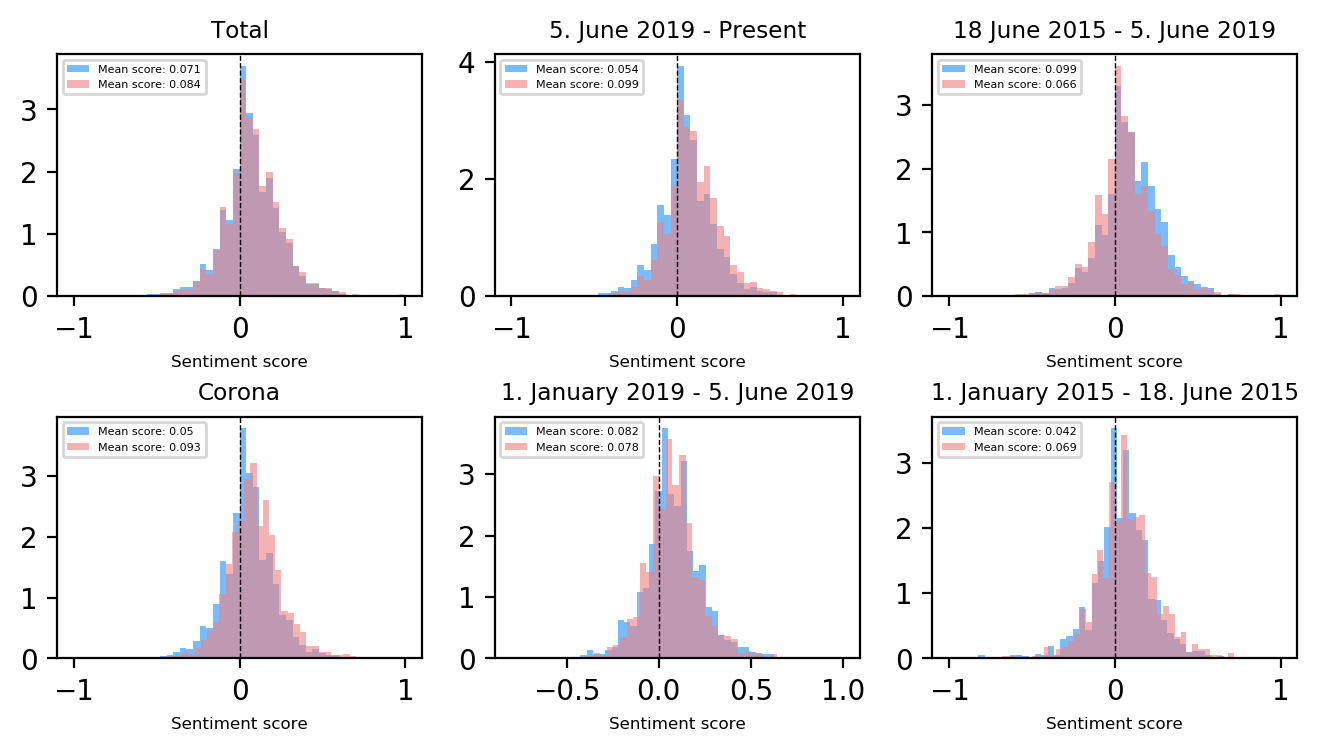

In [33]:
# Create histograms for each defined period

fig = plt.figure(figsize=(8, 4), dpi=200)
fig.subplots_adjust(hspace = 0.5)

kwargs_blue = {'bins':50, 'histtype':'stepfilled', 'alpha':0.6, 'density':True, 'color':'dodgerblue'}
kwargs_red = {'bins':50, 'histtype':'stepfilled', 'alpha':0.6, 'density':True, 'color':'lightcoral'}

ax_Total = fig.add_subplot(2,3,1)
ax_Total.hist(xb, label= 'Mean score: ' + str(round(db_total[1],3)),  **kwargs_blue)
ax_Total.hist(xr, label= 'Mean score: ' + str(round(dr_total[1],3)), **kwargs_red)
ax_Total.axvline(0,color='black',linestyle='--',linewidth=0.5)
ax_Total.set_title('Total',size = 'small')
ax_Total.set_xlabel('Sentiment score', fontsize=6)
ax_Total.legend(fontsize=4, loc='upper left')

ax_2019 = fig.add_subplot(2,3,2)
ax_2019.hist(xb_2019, label= 'Mean score: ' + str(round(db_2019[1],3)), **kwargs_blue)
ax_2019.hist(xr_2019, label= 'Mean score: ' + str(round(dr_2019[1],3)), **kwargs_red)
ax_2019.axvline(0,color='black',linestyle='--',linewidth=0.5)
ax_2019.set_title('5. June 2019 - Present',size='small')
ax_2019.set_xlabel('Sentiment score', fontsize=6)
ax_2019.legend(fontsize=4, loc='upper left')

ax_2017 = fig.add_subplot(2,3,3)
ax_2017.hist(xb_2017, label= 'Mean score: ' + str(round(db_2017[1],3)), **kwargs_blue)
ax_2017.hist(xr_2017, label= 'Mean score: ' + str(round(dr_2017[1],3)), **kwargs_red)
ax_2017.axvline(0,color='black',linestyle='--',linewidth=0.5)
ax_2017.set_title('18 June 2015 - 5. June 2019',size='small')
ax_2017.set_xlabel('Sentiment score', fontsize=6)
ax_2017.legend(fontsize=4, loc='upper left')

ax_corona = fig.add_subplot(2,3,4)
ax_corona.hist(xb_corona, label= 'Mean score: ' + str(round(db_corona[1],3)), **kwargs_blue)
ax_corona.hist(xr_corona, label= 'Mean score: ' + str(round(dr_corona[1],3)), **kwargs_red)
ax_corona.axvline(0,color='black',linestyle='--',linewidth=0.5)
ax_corona.set_title('Corona',size = 'small')
ax_corona.set_xlabel('Sentiment score', fontsize=6)
ax_corona.legend(fontsize=4, loc='upper left')

ax_2019_pre = fig.add_subplot(2,3,5)
ax_2019_pre.hist(xb_2019_pre, label= 'Mean score: ' + str(round(db_2019_pre[1],3)), **kwargs_blue)
ax_2019_pre.hist(xr_2019_pre, label= 'Mean score: ' + str(round(dr_2019_pre[1],3)), **kwargs_red)
ax_2019_pre.axvline(0,color='black',linestyle='--',linewidth=0.5)
ax_2019_pre.set_title('1. January 2019 - 5. June 2019',size='small')
ax_2019_pre.set_xlabel('Sentiment score', fontsize=6)
ax_2019_pre.legend(fontsize=4, loc='upper left')

ax_2017_pre = fig.add_subplot(2,3,6)
ax_2017_pre.hist(xb_2017_pre, label= 'Mean score: ' + str(round(db_2017_pre[1],3)), **kwargs_blue)
ax_2017_pre.hist(xr_2017_pre, label= 'Mean score: ' + str(round(dr_2017_pre[1],3)), **kwargs_red)
ax_2017_pre.axvline(0,color='black',linestyle='--',linewidth=0.5)
ax_2017_pre.set_title('1. January 2015 - 18. June 2015',size='small')
ax_2017_pre.set_xlabel('Sentiment score', fontsize=6)
ax_2017_pre.legend(fontsize=4, loc='upper left')

fig.savefig('Sentiment_scores.pdf') 

In [34]:
# Create a 6 month running average sentiment score across the blocks
def six_month_average(df):
    '''
    Input: 
    DataFrame

    Process of function:
    Computes 6 month running average sentiment score across the 2 political wings

    Output:
    Returns DataFrames with the computed averages
    '''
    df_blue = df[df['y']==1]
    df_red = df[df['y']==0]
    blue_sentiment_average_month = []
    red_sentiment_average_month = []
    dates = []
    

    date_list = df['Date'].sort_values().reset_index(drop=True).to_list()
    year, month = date_list[0].year, date_list[0].month
    end_year, end_month = date_list[-1].year, date_list[-1].month

    while (year < end_year) or (month < end_month):
        if month > 12: # execute next year
            year = year + 1 # Dont touch
            month = 1 # Dont touch
        else:
            date = str(year) + '-' + str(month) + '-01'
            if month == 12:
                date_next = str(year+1) + '-1-01'
            else:
                date_next = str(year) + '-' + str(month+1) + '-01'

            dates.append(date)
            
            df_blue_month = df_blue.loc[df_blue['Date'] >= date].reset_index(drop=True)
            df_blue_month = df_blue_month.loc[df_blue_month['Date'] < date_next].reset_index(drop=True)
            df_red_month = df_red.loc[df_red['Date'] >= date].reset_index(drop=True)
            df_red_month = df_red_month.loc[df_red_month['Date'] < date_next].reset_index(drop=True)

            blue_sentiment_average_month.append(df_blue_month['Sentiment'].mean())
            red_sentiment_average_month.append(df_red_month['Sentiment'].mean())

            
            month = month + 1 # Dont touch

    blue_moving_average = np.convolve(np.array(blue_sentiment_average_month), np.ones(6), 'valid')/6
    red_moving_average = np.convolve(np.array(red_sentiment_average_month), np.ones(6), 'valid')/6
         

    return blue_moving_average, red_moving_average, blue_sentiment_average_month, red_sentiment_average_month, dates

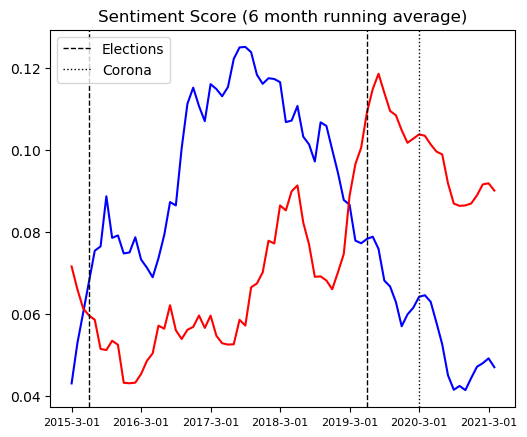

In [35]:
# Plotting the 6-month average of sentiment scores for the two political wings
a = six_month_average(df_plot)
dates = a[4][2:-3]

fig1 = plt.figure(figsize=(6, 5), dpi=100)

x_blue = np.array(np.arange(len(a[0])))
y_blue = np.array(a[0])
x_red = np.array(np.arange(len(a[1])))
y_red = np.array(a[1])

plt.xticks(x_blue[::12], dates[::12],fontsize=8)

plt.plot(x_blue, y_blue,color='blue')
plt.plot(x_red, y_red,color='red')
plt.title('Sentiment Score (6 month running average)')
plt.axvline(3,linestyle = '--', linewidth = 1, color='black')
plt.axvline(51,linestyle = '--', linewidth = 1, color='black',label='Elections')
plt.axvline(60,linestyle = ':', linewidth = 1, color='black',label='Corona')
plt.legend(loc='upper left')
# plt.show()
plt.savefig('Sentiment_timeseries.pdf')

In [23]:
# Retieve the top hashtags for the period from the last election and onwards until now
text = df_main_done.copy()

text = text.loc[text['Date'] >= '2019-06-05'].reset_index(drop=True)

df_hashtags_2019 = find_hashtags(text)

df_hashtags_2019 = df_hashtags_2019.sort_values('Count',ascending=False).reset_index(drop=True)
df_hashtags_2019[0:20]

,Word,Count
0,#dkpol,31466
1,#dkgreen,2956
2,#dkmedier,1551
3,#sundpol,938
4,#dktrp,843
5,#ftlive,691
6,#COVID19dk,559
7,#dkbiz,417
8,#dksocial,364
9,#uddpol,320


In [73]:
# Create a new dataframe for the ML model
df_model = df_main_done.copy()

list_of_words_model = df_hashtags_2019['Word'][0:20].to_list()

pattern_model = '|'.join(list_of_words_model)

df_model = df_model[df_model['Final Text'].str.contains(pattern_model)]
df_model = df_model.loc[df_model['Date'] >= '2015-01-01'].reset_index(drop=True)

df_model

,Date,Name,Party,Følgere,Tweet Count,Tweet,la,Likes,Retweets,Stems,Final Text,Sentiment,y
0,2021-06-09 08:36:50,Ida Auken,Socialdemokratiet (S),73.926,879,Svært ikke at være åbenhjertig ovor for så skø...,da,26,4,"[svært, åbenhjertig, ovor, så, skøn, samtalepa...",svært åbenhjertig ovor så skøn samtalepartner ...,-0.03,0
1,2021-06-03 08:24:02,Ida Auken,Socialdemokratiet (S),73.926,879,"Har skrevet lidt om et område, der virkelig ha...",da,20,2,"[skrevet, lidt, område, virkelig, halter, bagu...",skrevet lidt område virkelig halter bagud fht ...,-0.01,0
2,2021-06-02 07:38:40,Ida Auken,Socialdemokratiet (S),73.926,879,"På lidt over et år har vi taget beslutninger, ...",da,59,6,"[lidt, år, taget, beslutninger, bringer, halvd...",lidt år taget beslutninger bringer halvdelen v...,0.14,0
3,2021-05-26 09:54:50,Ida Auken,Socialdemokratiet (S),73.926,879,Har du endnu ikke set dokumentaren 70/30 om kl...,da,17,4,"[endnu, set, dokumentaren, 030, klimalovens, t...",endnu set dokumentaren 030 klimalovens tilbliv...,0.04,0
4,2021-05-24 19:34:25,Ida Auken,Socialdemokratiet (S),73.926,879,Ren luft i byen og et vigtigt skub til elbiler...,da,36,5,"[ren, luft, byen, vigtigt, skub, elbilerne, gl...",ren luft byen vigtigt skub elbilerne glæder ud...,0.21,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
62024,2017-05-08 05:03:36,Orla Østerby,Uden for folketingsgrupperne (UFG),596,51,En skræmmende undersøgelse - det her fortjener...,da,0,0,"[skræmmende, undersøgelse, fortjener, ingen, b...",skræmmende undersøgelse fortjener ingen børn #...,-0.4,1
62025,2017-05-04 08:17:37,Orla Østerby,Uden for folketingsgrupperne (UFG),596,51,Morgensang i Samtaleværelset. Netop i dag den ...,da,6,0,"[morgensang, samtaleværelset, netop, dag, 4, m...",morgensang samtaleværelset netop dag 4 maj san...,0.02,1
62026,2017-05-02 15:36:22,Orla Østerby,Uden for folketingsgrupperne (UFG),596,51,Godt nyt. Skattesatsen sænkes fra 1 procent ti...,da,2,0,"[godt, nyt, skattesatsen, sænkes, procent, 55,...",godt nyt skattesatsen sænkes procent 55 procen...,0.18,1
62027,2017-04-26 05:58:20,Orla Østerby,Uden for folketingsgrupperne (UFG),596,51,"Dagtilbudslederen skal overveje, hvordan man k...",da,2,0,"[dagtilbudslederen, overveje, hvordan, kan, in...",dagtilbudslederen overveje hvordan kan inddrag...,0.03,1


In [74]:
# implementing logistic regression with an ML model 
X, y = df_model['Final Text'], df_model['y']

# Dividing the dataset into a test and training set
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3,random_state=1)

# vectorize the text variable to get a array of features for the logistic regression
vect = CountVectorizer(ngram_range=(1,4), max_features = 200)
X_train = vect.fit_transform(X_train)
X_test = vect.fit_transform(X_test)

# Check distribution of political wings in the train and test set
print("We have " + str(np.round(sum(y_train)/len(y_train)*100,2)) + '% of blue tweets in our train')
print("We have " + str(np.round(sum(y_test)/len(y_test)*100,2)) + '% of blue tweets in our test')

We have 39.01% of blue tweets in our train
We have 38.58% of blue tweets in our test


In [75]:
# Look at the list of features
vect.get_feature_names()

['aftale',
 'aldrig',
 'alternativet',
 'andre',
 'ansvar',
 'arbejde',
 'bare',
 'bedre',
 'bla',
 'blevet',
 'brug',
 'bruge',
 'både',
 'bør',
 'børn',
 'corona',
 'covid19dk',
 'dag',
 'dagens',
 'danmark',
 'danmarks',
 'dansk',
 'danske',
 'danskerne',
 'debat',
 'del',
 'derfor',
 'desværre',
 'df',
 'dk',
 'dkaid',
 'dkbiz',
 'dkgreen',
 'dkgreen dkpol',
 'dkmedier',
 'dkpol',
 'dkpol dkgreen',
 'dkpol dkmedier',
 'dkpol dktrp',
 'dkpol ftlive',
 'dkpol sundpol',
 'dksocial',
 'dktrp',
 'endnu',
 'enhedslisten',
 'enig',
 'eu',
 'eudk',
 'fik',
 'finde',
 'flere',
 'flertal',
 'fokus',
 'folk',
 'folketinget',
 'fordi',
 'forslag',
 'frederiksen',
 'frem',
 'ftlive',
 'få',
 'fået',
 'får',
 'før',
 'første',
 'gang',
 'gerne',
 'give',
 'giver',
 'glad',
 'glæder',
 'god',
 'gode',
 'godt',
 'grøn',
 'grønne',
 'gå',
 'går',
 'gør',
 'gøre',
 'hele',
 'helt',
 'hjælp',
 'holde',
 'hvordan',
 'hvorfor',
 'håber',
 'igen',
 'imod',
 'ingen',
 'ja',
 'kan',
 'klar',
 'klima',
 'k

In [ ]:
# fit the model on the training data and calculate predictions on the test data
model = LogisticRegression(max_iter = 1000, solver = 'saga', penalty ='l1', fit_intercept=True ).fit(X_train,y_train)
y_pred = model.predict(X_test)
y_pred = y_pred

In [ ]:
print('Our testset is: ' + str(len(y_test)) + ' observation \nTrue: ' + str(y_test.sum()) + ' Blue tweets' )
a = y_pred == y_test
print('We found: ' + str(y_pred.sum()) + ' Blue tweets \nWe predicted: ' + str(np.round(a.mean()*100,2)) + ' % correct tweets overall')
a = Counter(y_pred-y_test)

print('\nWe missed to predict: ' + str(a[-1]) + ' Tweets \n\nOf the predicted Blue (' + str(y_pred.sum()) + ') \nCorrect prediction: ' + str(y_pred.sum()-a[1]) + '\nWrong prediction: ' + str(a[1]))

print('\nOf the predicted Red (' + str(len(y_pred) - y_pred.sum()) + ') \nCorrect prediction: ' + str(len(y_pred) - y_pred.sum()-a[-1]) + '\nWrong prediction: ' + str(a[-1]))



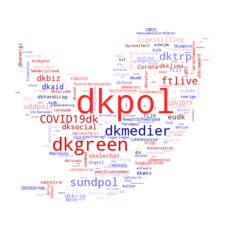

In [37]:
# Constructing a wordcloud image for the frontpage
df_word_cloud = df_hashtags_2019.copy()

number_of_words = 997

text_word = df_word_cloud['Word'][0:number_of_words].to_list()
text_count = df_word_cloud['Count'][0:number_of_words].to_list()

text_wc = sum([[s] * n for s,n, in zip(text_word,text_count)], [])

text_wc = ' '.join(text_wc)


# mask = np.array(Image.open('Twitterlogo.png'))
size = (500,500)
mask = np.array(Image.open('Twitterlogo1.png').convert('L').resize(size))

colors_wc = ()

word_cloud = WordCloud(collocations = False,colormap='seismic',  background_color = 'white',mask=mask,width=400,height=400).generate(text_wc) #width=1000,height=1000


# plt.imshow(mask, cmap=plt.cm.gray, interpolation='bilinear')
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis("off")
plt.show()
word_cloud.to_file('WordCloud.png')
